In [1]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb

# import sys 
# sys.path.append('../')
#import feature_cleaning as feature_cleaning

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


#sklearn models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#sklearn other
#import graphviz 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, log_loss, accuracy_score, roc_auc_score, auc, roc_curve
#from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

In [2]:
edu_df = pd.read_csv('edu_df_15.csv')

# split the data, choosing only edu cols
X = edu_df.drop(columns=[ 'Unnamed: 0', 'SERIALNO', 'FOD1P', 'FOD2P','SOCP','MAJ_SOCP','MAJ_SOCP_labels', 
                'MAJ_SOCP_15','FOD1P_labels','FOD2P_labels','SCHL',
                'SCHL_labels','FOD1P_MAJ_labels', 'FOD1P_MAJ'])
y = edu_df.loc[:,'MAJ_SOCP']

y.head()

0    17
1    13
2    13
3    39
4    43
Name: MAJ_SOCP, dtype: int64

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

In [4]:

# model pipelines
#-----------------------------------
#-------------linear
pipe_lr = Pipeline([('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42))])

pipe_lr_l2 = Pipeline([('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42))])

pipe_sgd = Pipeline([('scl', StandardScaler()),
            ('clf', SGDClassifier(random_state=42))])


#-------------trees
pipe_dt = Pipeline([('clf', DecisionTreeClassifier(random_state=42))])

pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=42))])

pipe_rf_scl = Pipeline([('scl', StandardScaler()),
            ('clf', RandomForestClassifier(random_state=42))])

pipe_gb = Pipeline([('clf', GradientBoostingClassifier(random_state=42))])


#-------------SVM
pipe_svm = Pipeline([('scl', StandardScaler()),
            ('clf', SVC(random_state=42))])


#-------------KNN
pipe_knn = Pipeline([('clf', KNeighborsClassifier())])

pipe_knn_scl = Pipeline([('scl', StandardScaler()),
            ('clf', KNeighborsClassifier())])

#-----------------------------------

#-------------XGB
pipe_xgb = Pipeline([('clf', xgb.XGBClassifier())])
#-----------------------------------


# grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]
max_depth = [10,100,1000,10000]
max_depth2 = [10,100,1000]
alpha_range = [.1, .001, .00001, .000001]
gamma_range = [.1, 1, 10]

#-------------linear
grid_params_lr = [{'clf__penalty': ['l1'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear', ],  #,'saga'
        #'clf__multi_class': ['ovr', 'multinomial', 'auto'],
        'clf__class_weight': [None, 'balanced']}] 

grid_params_lr_l2 = [{'clf__penalty': ['l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],  #, 'sag'
        #'clf__multi_class': ['ovr', 'multinomial', 'auto'],
        'clf__class_weight': [None, 'balanced']}]

grid_params_sgd = [{'clf__loss': ['hinge', 'log', 'perceptron'],
        'clf__alpha': alpha_range,
        'clf__penalty': ['l1', 'l2', 'elasticnet'],
        'clf__class_weight': [None, 'balanced']}] 

#-------------trees
grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': max_depth,
        'clf__min_samples_split': param_range[1:],
        'clf__class_weight': [None, 'balanced']}]

grid_params_rf = [{'clf__criterion': ['entropy'],
        'clf__min_samples_leaf': [1],
        'clf__max_depth': [1000],
        'clf__min_samples_split': [10],
        'clf__class_weight': [None],
        'clf__n_estimators':[10]}]

#<3
grid_params_gb = [{'clf__loss': ['deviance', 'exponential'],
        'clf__learning_rate': alpha_range,
        'clf__n_estimators': max_depth2,
        'clf__subsample': param_range_fl}]

#-------------SVM
grid_params_svm = [{'clf__kernel': ['linear', 'rbf', 'poly'],
        'clf__degree': param_range[1:],
        'clf__gamma': gamma_range,
        'clf__C': gamma_range,
        'clf__class_weight': [None, 'balanced']}]

#-------------KNN
grid_params_knn = [{'clf__n_neighbors': param_range}]

#-------------XGB

grid_params_xgb = [{}]

# #'clf__n_estimators': max_depth2,
#                    'clf__max_depth': max_depth,
#                    'clf__learning_rate':gamma_range

#--------------------------------------------------------------

# Construct grid searches
jobs = -1
verbose = 2

#-------------linear
gs_lr = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose) 

gs_lr_l2 = GridSearchCV(estimator=pipe_lr_l2,
            param_grid=grid_params_lr_l2,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose)

gs_sgd = GridSearchCV(estimator=pipe_sgd,
            param_grid=grid_params_sgd,
            scoring='f1_micro',
            cv=10,
            verbose=verbose)


#-------------trees    
gs_dt = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_dt,
            scoring='f1_micro',
            cv=10, 
            n_jobs=jobs,
            verbose=verbose)

gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring='f1_micro',
            cv=10, 
            n_jobs=jobs,
            verbose=verbose)

gs_rf_scl = GridSearchCV(estimator=pipe_rf_scl,
            param_grid=grid_params_rf,
            scoring='f1_micro',
            cv=10, 
            n_jobs=jobs,
            verbose=verbose)

gs_gb = GridSearchCV(estimator=pipe_gb,
            param_grid=grid_params_gb,
            scoring='f1_micro',
            cv=10, 
            verbose=verbose)

#-------------SVM

gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=grid_params_svm,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose)

#-------------KNN
gs_knn = GridSearchCV(estimator=pipe_knn,
            param_grid=grid_params_knn,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose)

gs_knn_scl = GridSearchCV(estimator=pipe_knn_scl,
            param_grid=grid_params_knn,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose)

#-------------XGB
gs_xgb = GridSearchCV(estimator=pipe_xgb,
            param_grid=grid_params_xgb,
            scoring='f1_micro',
            cv=10, 
            verbose=verbose)

#---------------------------------------------------------------------

# List of pipelines for ease of iteration
grids = [ gs_xgb]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0:'xgb'}

# Fit the grid search objects
print('Performing model optimizations...')
best_f1_micro = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs = gs.fit(X_train, y_train)

    # Best params
    print('Best params: %s' % gs.best_params_)

    # Best training data f1
    print('Best training f1: %.3f' % gs.best_score_)

    # Predict on test data with best params
    y_pred = gs.predict(X_test)

    #accuracy
    print('test accuracy {}:'.format( accuracy_score(y_test, y_pred)))
    
    #auc
    print('test auc {}:'.format( roc_auc_score(y_test, y_pred)))

    # Test data accuracy of model with best params
    print('Test set f1 score for best params: %.3f ' % f1_score(y_test, y_pred))

    # Track best (highest test f1) model
    if f1_score(y_test, y_pred) > best_f1_micro:
        best_f1_micro = f1_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set f1: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
dump_file = 'best_model_no_feat_sel_extr_occ_15.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: xgb
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.2min remaining:    0.0s


[CV] ................................................. , total=13.0min
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ................................................. , total=13.1min
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ................................................. , total=13.0min
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ................................................. , total=12.9min
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ................................................. , total=12.9min
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ................................................. , total=13.1min
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ................................................. , total=12.9min
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ................................................. , total=12.9min
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ................................................. , total=13.0min
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 131.3min finished


[CV] ................................................. , total=12.9min
Best params: {}
Best training f1: 0.215
test accuracy 0.21591594177934717:


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ValueError: multiclass format is not supported

In [7]:
f1_score(y_test, y_pred, average='micro')

0.2159159417793472

In [8]:
gs.best_estimator_.named_steps["clf"].feature_importances_ 

array([3.5968819e-01, 8.6117294e-03, 6.9784708e-03, 1.4105419e-03,
       1.4105420e-02, 2.1677803e-02, 1.5367484e-02, 4.7512990e-03,
       1.0690423e-02, 2.5241277e-03, 5.1224944e-03, 2.6429102e-02,
       5.7906457e-03, 4.8997775e-03, 5.4936898e-03, 1.7817372e-03,
       8.3890129e-03, 1.9302153e-03, 1.0913140e-02, 0.0000000e+00,
       1.3363028e-03, 0.0000000e+00, 4.8997775e-03, 0.0000000e+00,
       0.0000000e+00, 1.2620639e-03, 4.8255380e-03, 0.0000000e+00,
       9.6510760e-03, 1.7074981e-03, 2.6726057e-03, 1.1135858e-02,
       1.3808464e-02, 1.7817372e-03, 0.0000000e+00, 1.0244989e-02,
       2.0786934e-03, 2.5983667e-03, 8.3890129e-03, 4.0831477e-03,
       0.0000000e+00, 1.8559763e-03, 1.0393467e-03, 0.0000000e+00,
       2.5241277e-03, 1.0393467e-03, 7.4239052e-04, 6.6815142e-04,
       3.7119526e-04, 0.0000000e+00, 0.0000000e+00, 6.6815142e-04,
       4.3058647e-03, 1.4847810e-04, 2.9695619e-04, 1.2620639e-03,
       1.4847810e-03, 7.9435781e-03, 2.3014105e-03, 0.0000000e

In [10]:
xgbimportances = gs.best_estimator_.named_steps["clf"].feature_importances_ 
indices = np.argsort(xgbimportances)[::-1][0:9]

''

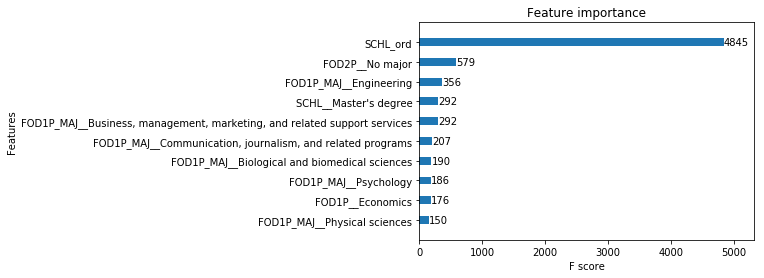

In [18]:
plt.Figure(figsize=(10,30))
xgb.plot_importance(gs.best_estimator_.named_steps["clf"], grid=False, height=.4, max_num_features=10)
;